
# COVID19 Exposure Notification System Risk Simulator

kpmurphy@google.com,  serghiou@google.com

(broken link)

Last update: 22 August 2020


## References

We base our approach on these papers


* [Quantifying SARS-CoV-2-infection risk withing the Apple/Google exposure notification framework to inform quarantine recommendations](https://www.medrxiv.org/content/10.1101/2020.07.17.20156539v1), Amanda Wilson, Nathan Aviles,  Paloma  Beamer, Zsombor Szabo, Kacey  Ernst, Joanna Masel. July 2020

* [The timing of COVID-19 transmission](https://www.medrxiv.org/content/10.1101/2020.09.04.20188516v1.abstract), Luca Ferretti et al, Sept. 2020

* [Risk scoring in contact tracing apps](https://drive.google.com/file/d/14v9aCBzv5OehFQfQqs9a7xZhdjlKmszd/view?usp=sharing), Mark Briers, Marcos Charalambides, Christophe Fraser, Chris Holmes, Radka Jersakova, James Lomax, and Tom Lovett. 26 July 2020


In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

from collections import namedtuple
from enum import Enum, IntEnum
from dataclasses import dataclass

import matplotlib.cm as cm
import sklearn
from sklearn import metrics

# Configure plot style sheet
plt.style.use('fivethirtyeight')
plt.rcParams['axes.titlesize'] = 'medium'  # can take 'large', 'x-large'
plt.rcParams['axes.labelsize'] = 'medium'

In [ ]:
import jax
import jax.numpy as jnp

# Infectiousness vs time since onset of symptoms (TOST)



Let $\Delta=T^e - T^s$ be the time between when Alice got exposed to Bob
and when Bob first showed symptoms. Let $f_{\rm{inf}}(\Delta)$ be the infectiousness.

## Gaussian approximation

We use the Gaussian approximation from the following paper.

* [Risk scoring in contact tracing apps](), Mark Briers, Marcos Charalambides, Christophe Fraser, Chris Holmes, Radka Jersakova, James Lomax, and Tom Lovett. 26 July 2020


$$
f_{inf}(\Delta) = \exp\left(
  -\frac{ (\Delta - \mu)^2 }{2 \sigma^2} \right)
$$

where   $\mu=-0.3$ , $\sigma=2.75$ (units of days).

We plot this below.

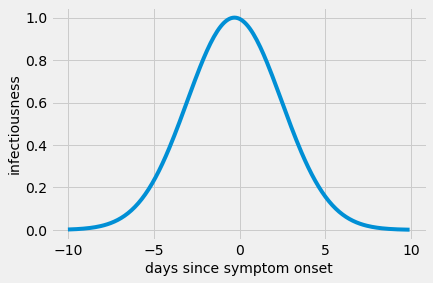

In [ ]:
def infectiousness_gaussian(deltas):
  mu = -0.3; s = 2.75;
  ps = np.exp(- np.power(deltas-mu,2) / (2*s*s))
  return ps

deltas = np.arange(-10, 10, 0.1)
ps = infectiousness_gaussian(deltas)
plt.figure();
plt.plot(deltas, ps)
plt.xlabel('days since symptom onset');
plt.ylabel('infectiousness');


## Skew-logistic distribution

In Ferretti et al 2020, they note that the infectiousness profile varies depending on the incubation period. We model this as shown below.



In [ ]:
def skew_logistic_scaled(x, alpha, mu, sigma):
  return scipy.stats.genlogistic.pdf(x, alpha, loc=mu, scale=sigma)

def ptost_conditional(ts, incubation):
  mu = -4
  sigma = 1.85
  alpha = 5.85
  tau = 5.42
  fpos = skew_logistic_scaled(ts, alpha, mu, sigma)
  #fneg = skew_logistic_scaled(ts, alpha, mu, sigma*incubation/tau) # error in paper
  fneg = skew_logistic_scaled(ts*tau/incubation, alpha, mu, sigma)
  ps = fpos
  neg = np.where(ts < 0)
  ps[neg] = fneg[neg]
  ps = ps/np.max(ps)
  return ps

def incubation_dist(t):
  mu = 1.621
  sig = 0.418
  rv = scipy.stats.lognorm(sig, scale=np.exp(mu))
  return rv.pdf(t)

def ptost_uncond(tost_times):
  #p(t) = sum_{k=1}^14 p(incubation=k) ptost(t | k) / max_t( ptost(t|k) )
  incub_times = np.arange(1, 14, 1)
  incub_probs = incubation_dist(incub_times)
  tost_probs = np.zeros_like(tost_times, dtype=float)
  for k, incub in enumerate(incub_times):
    ps = ptost_conditional(tost_times, incub)
    tost_probs += incub_probs[k] * ps
  #tost_probs = tost_probs/np.max(tost_probs)
  return tost_probs

infectiousness_curve_times = np.arange(-14, 14+1, 0.1)
infectiousness_curve_vals = ptost_uncond(infectiousness_curve_times)

def infectiousness_skew_logistic(delta):
  return np.interp(delta, infectiousness_curve_times, infectiousness_curve_vals)

print(infectiousness_skew_logistic(5))
print(infectiousness_skew_logistic(np.array([5])))

0.12503200521081842
[0.12503201]


Text(0, 0.5, 'prob(transmission)')

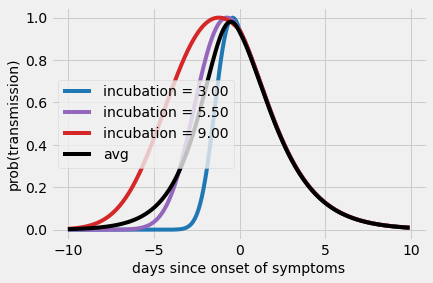

In [ ]:
tost = np.arange(-10, 10, 0.1)
incubs = np.array([3, 5.5, 9])
#https://matplotlib.org/3.1.1/tutorials/colors/colors.html
colors = ['tab:blue', 'tab:purple', 'tab:red']
plt.figure()
for i, incub in enumerate(incubs):
  ps = ptost_conditional(tost, incub)
  #ps = ps/np.max(ps)
  name = 'incubation = {:0.2f}'.format(incub)
  plt.plot(tost, ps, label=name, color=colors[i])
ps = ptost_uncond(tost)
ps = [infectiousness_skew_logistic(t) for t in tost]
qs = infectiousness_skew_logistic(tost)
assert np.allclose(ps, qs)
plt.plot(tost, ps, label='avg', color='k')
plt.legend()
plt.xlabel('days since onset of symptoms')
plt.ylabel('prob(transmission)')

# Dose vs distance








Briers (2020) propose the following quadratic model
$$
g(d) =  \min(1, D^2_{\min}/d^2)
 $$
They set
$D^2_{\min}=1$  based on argument of the physics of droplet spread.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


Text(0, 0.5, 'dose')

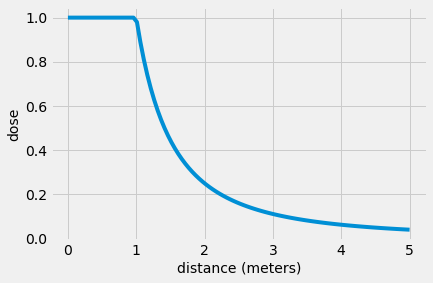

In [ ]:

def dose_curve_quadratic(d, Dmin=1):
  Dmin = 1
  m = np.power(Dmin,2)/np.power(d, 2)
  return np.minimum(1, m)

d = np.linspace(0, 5, 100)
p = dose_curve_quadratic(d)
plt.figure()
plt.plot(d, p)
plt.xlabel('distance (meters)');
plt.ylabel('dose')

Wilson (2020) use a physical simulator of droplet spread. We fit a cubic spline to their Monte Carlo simulation. Results are shown below.

In [ ]:
# from scipy.interpolate import splev, splrep

# def dose_curve_spline_fit():
#   url = "https://raw.githubusercontent.com/probml/covid19/master/WilsonMasel/stelios-dose-data-scaled.csv"
#   df = pd.read_csv(url)
#   distances = df['distance'].to_numpy()
#   doses = df['dose'].to_numpy()
#   ndx1 = (distances <= 1)
#   ndx2 = (distances > 1)
#   x = distances[ndx1]
#   y = doses[ndx1]
#   spline1 = splrep(x, y)  # (t, c, k), contains knots, coefficients, degree
#   x = distances[ndx2]
#   y = doses[ndx2]
#   spline2 = splrep(x, y)
#   return spline1, spline2

# def dose_curve_spline(x, spline1, spline2):
#   if np.isscalar(x):
#     x = np.array([x])
#     scalar = True
#   else:
#     scalar = False
#   n = len(x)
#   ndx = np.where(x <= 1)
#   y1 = splev(x, spline1)
#   y2 = splev(x, spline2)
#   y = np.zeros(n)
#   y[x <= 1] = y1[x <= 1]
#   y[x > 1] = y2[x > 1]
#   if scalar:
#     y = y[0]
#   return y

# spline1, spline2 = dose_curve_spline_fit()
# d = np.linspace(0, 5, 100)
# p = dose_curve_spline(d, spline1, spline2)
# plt.figure()
# plt.plot(d, p)
# plt.xlabel('distance (meters)');
# plt.ylabel('dose')
# plt.yscale('log')

# Bluetooth simulator

Text(0, 0.5, 'distance (m)')

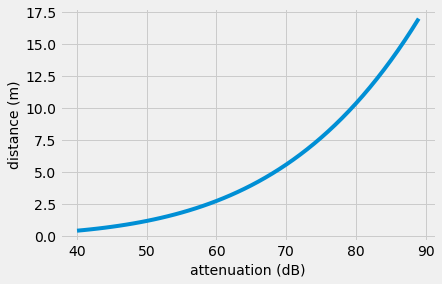

In [ ]:

# Lovett paper https://arxiv.org/abs/2007.05057
# Lognormal noise model
# mu = slope * log(distance) + intercept'
# log(-rssi) ~ N(mu, sigma)
# E log(-R) = slope*log(D) + inter
# D = exp( (log(-R) - inter) / slope)
# attenuation = tx - rx - rssi

def atten_to_dist(atten, params):
  rssi = params.tx  - (atten + params.correction)
  return np.exp((np.log(-rssi) - params.intercept)/params.slope)

def dist_to_atten(distance, params):
  mu = params.intercept + params.slope * np.log(distance)
  rssi = -np.exp(mu)
  atten = params.tx  - (rssi + params.correction)
  return atten

def dist_to_atten_sample_lognormal(distances, params):
    if params.sigma == 0:
      return dist_to_atten(distances, params)
    N = len(distances)
    mus = params.intercept + params.slope * np.log(distances)
    rssi = -scipy.stats.lognorm(s=params.sigma, scale=np.exp(mus)).rvs()
    atten = params.tx  - (rssi + params.correction)
    return atten

# We use regression parameters from Fig 4 of
# Lovett paper https://arxiv.org/abs/2007.05057
# estimated from H0H1 data

@dataclass
class BleParams:
  slope: float = 0.21
  intercept: float = 3.92
  sigma: float = np.sqrt(0.33)
  tx: float = 0.0
  correction: float=2.398
  name: str = 'briers-lognormal'

ble_params = BleParams()

attens = np.arange(40, 90)
distances = atten_to_dist(attens, ble_params)

fig, axs = plt.subplots(1,1)
axs = np.reshape(axs, (1,))
ax = axs[0]
ax.plot(attens, distances)
ax.set_xlabel('attenuation (dB)')
ax.set_ylabel('distance (m)')

In [ ]:
np.sqrt(0.33)

0.5744562646538028

### Noisy simulation

In [ ]:

ble_params_mle = BleParams(sigma=np.sqrt(0.33), name = 'briers-mle')
ble_params_low_noise = BleParams(sigma=0.01, name = 'briers-low-noise')
ble_params_no_noise = BleParams(sigma=0, name = 'briers-no-noise')

ble_params_list = [ble_params_no_noise, ble_params_low_noise, ble_params_mle]

distances  = []
nrep = 100
for d in range(1, 10+1):
    for i in range(nrep):
        distances.append(d)
distances = np.array(distances)


fig, axs = plt.subplots(1,3, figsize=(15,5))
axs = np.reshape(axs, (3,))
for i, params in enumerate(ble_params_list):
    mu = dist_to_atten(distances, params)
    np.random.seed(0)
    attens = dist_to_atten_sample_lognormal(distances, params)
    ax = axs[i]
    ax.plot(mu, '-', linewidth=3)
    ax.plot(attens, '.')
    ax.set_ylabel('attenuation (dB)')
    ax.set_xlabel('sample')
    ax.set_title(params.name)
    #fname = '../Figures/bluetoothSamples_{}.png'.format(params.name)
    #plt.savefig(fname)



# Probability of getting infected

This depends on 3 factors: how long was the exposure, how far, and how infectious was the transmitter.

In [ ]:
@dataclass
class Exposure:
  duration: float = np.nan
  distance: float = np.nan
  atten: float = np.nan
  days_exp: int = np.nan # days since exposure
  days_sym: int = np.nan # days since symptom onset

@dataclass
class ModelParams:
  ble_params: BleParams = ble_params
  distance_fun: str = 'quadratic' # quadratic or spline
  Dmin: float = 1
  infectiousness_fun: str = 'skew-logistic' # gaussian or skew-logistic
  beta: float = 1e-3

params = ModelParams()

def compute_dose(expo, params):
  if not np.isnan(expo.atten):
    dist = atten_to_dist(expo.atten, params.ble_params)
  else:
    dist = expo.distance
  if params.distance_fun == 'quadratic':
    fd = dose_curve_quadratic(dist, params.Dmin)
  elif params.distance_fun == 'spline':
    fd = dose_curve_spline(dist)
  else:
    fd = 1
  if not np.isnan(expo.days_sym):
    if params.infectiousness_fun == 'gaussian':
      finf = infectiousness_gaussian(expo.days_sym)
    elif params.infectiousness_fun == 'skew-logistic':
      finf = infectiousness_skew_logistic(expo.days_sym)
    else:
      finf = 1
  else:
    finf = 1
  dose  = expo.duration * fd * finf
  return dose


def prob_infection(expo, params):
  dose = compute_dose(expo, params)
  return 1-np.exp(-params.beta * dose)

def prob_infections(exposures, params):
  dose = 0
  for expo in exposures:
    dose += compute_dose(expo, params)
  return 1-np.exp(-params.beta * dose)

def prob_infection_batch(attenuations, durations, symptom_days, params, distances=None):
  if distances is None:
    distances = atten_to_dist(attenuations, params.ble_params)
  if params.distance_fun == 'quadratic':
    fd = dose_curve_quadratic(distances)
  elif params.distance_fun == 'spline':
    fd = dose_curve_spline(distances)
  if params.infectiousness_fun == 'gaussian':
    finf = infectiousness_gaussian(symptom_days)
  elif params.infectiousness_fun == 'skew-logistic':
    finf = infectiousness_skew_logistic(symptom_days)
  doses  = durations * fd * finf
  return 1-np.exp(-params.beta * doses)


In [ ]:


distances = np.array([0.8, 0.9, 1.0, 1.1, 1.2, 1.5, 2.0])
dur = 8*60
ps = []
for dist in distances:
  expo = Exposure(distance=dist, duration=dur, days_sym = 0)
  p = prob_infection(expo, params)
  ps.append(p)

qs = prob_infection_batch(None, dur, 0, params, distances)
assert np.allclose(ps, qs)
print(ps)



[0.36081508615901503, 0.36081508615901503, 0.36081508615901503, 0.3091865937001196, 0.26714439462336137, 0.18038143878033708, 0.10585772449310271]


# Risk score

In [ ]:
# https://enconfig.storage.googleapis.com/enconfig_fixed.html

@dataclass
class RiskConfig:
    ble_thresholds: np.array  = np.array([])
    ble_weights: np.array  = np.array([])
    inf_levels: np.array  = np.array([])
    inf_weights: np.array  = np.array([])
    name: str = ''
    beta: float = 3.1 * 1e-6 # Wilson table 1



## Attenuation

In [ ]:

config_swiss = RiskConfig(ble_thresholds = np.array([53, 60]),
                          ble_weights = np.array([1.0, 0.5, 0.0]),
                          name= 'Switzerland')

config_germany = RiskConfig(ble_thresholds = np.array([55, 63]),
                          ble_weights = np.array([1.0, 0.5, 0.0]),
                          name= 'Germany')

config_ireland = RiskConfig(ble_thresholds = np.array([56, 62]),
                          ble_weights = np.array([1.0, 1.0, 0.0]),
                          name= 'Ireland')

config_wilson = RiskConfig(ble_thresholds = np.array([50, 70]),
                           ble_weights = np.array([2.39, 0.6, 0.06]),
                           name= 'Arizona')


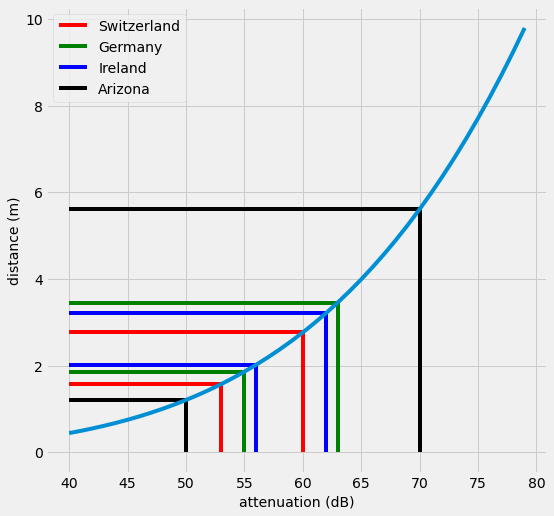

In [ ]:
config_list = [config_swiss, config_germany, config_ireland, config_wilson]

attens = np.arange(40, 80)
distances = atten_to_dist(attens, ble_params)

fig, axs = plt.subplots(1,1, figsize=(8,8))
axs = np.reshape(axs, (1,))
ax = axs[0]
ax.plot(attens, distances)
ax.set_xlabel('attenuation (dB)')
ax.set_ylabel('distance (m)')

names = [config.name for config in config_list]
colors = ['r', 'g', 'b', 'k']
handles = []
for i, config in enumerate(config_list):
    for j, thresh in enumerate(config.ble_thresholds):
      dist =  atten_to_dist(thresh, ble_params)
      handle = ax.vlines(thresh, 0, dist, color=colors[i])
      ax.hlines(dist, np.min(attens), thresh, color=colors[i])
      if j==0:
        handles.append(handle)
ax.legend(handles, names)
plt.show()

In [ ]:
def attenuation_score(atten, thresholds, weights):
  bin = np.digitize(atten, thresholds)
  watten = weights[bin]
  return watten

def attenuation_score_batch(attenuations, thresholds, weights):
  attenuations = np.atleast_1d(attenuations)
  labels = np.digitize(attenuations, thresholds)
  vecs = jax.nn.one_hot(labels, num_classes = len(weights))
  tmp = jnp.multiply(weights, vecs)
  scores = jnp.sum(tmp, 1)
  return scores

thresholds = np.array([50, 70])
weights = np.array([2.39, 0.6, 0.06])
attens = np.array([40, 52, 66, 99])
buckets = np.digitize(attens, thresholds)
print(buckets)
ps = [attenuation_score(a, thresholds, weights) for a in attens]
qs = attenuation_score_batch(attens, thresholds, weights)
assert np.allclose(ps, qs)
rs = np.array([attenuation_score_batch(a, thresholds, weights) for a in attens]).flatten()
assert np.allclose(ps, rs)

[0 1 1 2]


## Infectiousness levels

Here is a figure from Wilson et al, "Quantifying SARS-CoV-2 infection risk within the Google/Apple exposure notification framework to inform quarantine recommendations". Colors are the 6 transmission levels supported by GAEN v1.1.



<img src="https://github.com/probml/covid19/blob/master/Figures/infectiousness-TOST-MaselFig5A.png?raw=true">



In [ ]:
def make_infectiousness_params_v1():
  inf_pre = np.zeros((9), dtype=int)
  inf_post = np.zeros((5), dtype=int)
  inf_mid = np.array([1, 3, 4, 5, 6, 6, 6, 6, 5, 4, 3, 2, 2, 1, 1])
  inf_levels = np.concatenate((inf_pre, inf_mid, inf_post))
  inf_weights = np.array([0, 10**1, 10**1.2, 10**1.4, 10**1.6, 10**1.8, 10**2])
  return inf_levels, inf_weights

def make_infectiousness_params_v2():
  inf_pre = np.zeros((9), dtype=int)
  inf_post = np.zeros((5), dtype=int)
  inf_mid6 = np.array([1, 3, 4, 5, 6, 6, 6, 6, 5, 4, 3, 2, 2, 1, 1])
  inf_mid = np.ones_like(inf_mid6)
  ndx = (inf_mid6 >= 5)
  inf_mid[ndx] = 2
  #inf_mid = np.array([1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1])
  inf_levels = np.concatenate((inf_pre, inf_mid, inf_post))
  inf_weights = np.array([0,  10**1.6, 10**2])
  return inf_levels, inf_weights

def infectiousness_score(days_since_symptoms, inf_levels, inf_weights):
   # days_since_symptoms can be -14..14
  i = days_since_symptoms+14
  level = inf_levels[i]
  return inf_weights[level]


def infectiousness_score_batch(symptom_days, inf_levels, inf_weights):
  # symptom_days is an array of ints in -14..14
  symptom_days = np.atleast_1d(symptom_days)
  inf_labels = inf_levels[symptom_days + 14]
  inf_vecs = jax.nn.one_hot(inf_labels, num_classes = len(inf_weights))
  tmp  = jnp.multiply(inf_weights, inf_vecs)
  scores = jnp.sum(tmp, 1)
  return scores


In [ ]:
# debugging

ts = np.arange(0, 5, 1)
levels, weights = make_infectiousness_params_v1()
ps = [infectiousness_score(t, levels, weights) for t in ts]
qs = infectiousness_score_batch(ts, levels, weights)
assert np.allclose(ps, qs)

qs = [infectiousness_score_batch(t, levels, weights) for t in ts]
qs2 = np.array(qs).flatten()
print(ps)
print(qs)
print(qs2)
assert np.allclose(ps, qs2)

[100.0, 100.0, 100.0, 63.09573444801933, 39.810717055349734]
[DeviceArray([100.], dtype=float32), DeviceArray([100.], dtype=float32), DeviceArray([100.], dtype=float32), DeviceArray([63.095734], dtype=float32), DeviceArray([39.81072], dtype=float32)]
[100.       100.       100.        63.095734  39.81072 ]


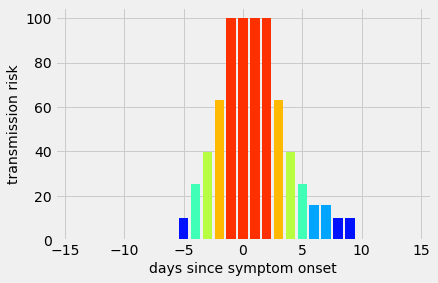

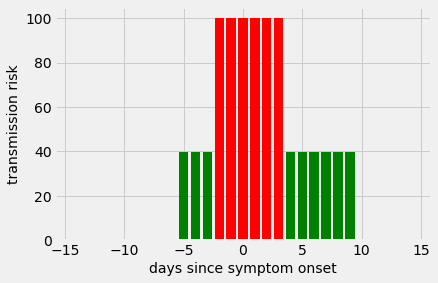

In [ ]:
ts = np.arange(-14, 14+1, 1)
levels, weights = make_infectiousness_params_v1()
ps = infectiousness_score_batch(ts, levels, weights)
import matplotlib.cm as cm
cmap = cm.get_cmap('jet')
colors = [cmap(c/7) for c in levels]
plt.figure()
plt.bar(ts, ps, color = colors)
plt.xlabel('days since symptom onset');
plt.ylabel('transmission risk');

levels, weights = make_infectiousness_params_v2()
ps = infectiousness_score_batch(ts, levels, weights)
palette =['black', 'green', 'red']
colors = [palette[c] for c in levels]
plt.figure()
plt.bar(ts, ps, color = colors)
plt.xlabel('days since symptom onset');
plt.ylabel('transmission risk');

## Probabilistic risk

In [ ]:
def risk_score(expo, config):
  winf = infectiousness_score(expo.days_sym, config.inf_levels, config.inf_weights)
  watten = attenuation_score(expo.atten, config.ble_thresholds, config.ble_weights)
  return expo.duration * watten * winf

def prob_risk_score(expo, config):
  r = risk_score(expo, config)
  return 1-np.exp(-config.beta * r)

# Same interface as
# prob_infection_batch(attenuations, durations, symptom_days, params)
def prob_risk_score_batch(attenuations, durations, symptom_days, config):
  attenuations = np.atleast_1d(attenuations)
  durations = np.atleast_1d(durations)
  symptom_days = np.atleast_1d(symptom_days)
  winf = infectiousness_score_batch(symptom_days, config.inf_levels, config.inf_weights)
  watten = attenuation_score_batch(attenuations, config.ble_thresholds, config.ble_weights)
  risks = durations * watten * winf
  return 1-np.exp(-config.beta * risks)

# Risk score plots

In [ ]:
levels, weights = make_infectiousness_params_v1()
config_wilsonv1 = RiskConfig(ble_thresholds = np.array([50, 70]),
                           ble_weights = np.array([2.39, 0.6, 0.06]),
                           inf_weights = weights,
                           inf_levels = levels,
                           name = 'thresh2_inf6')

levels, weights = make_infectiousness_params_v2()
config_wilsonv2 = RiskConfig(ble_thresholds = np.array([50, 70]),
                           ble_weights = np.array([2.39, 0.6, 0.06]),
                           inf_weights = weights,
                           inf_levels = levels,
                           name = 'thresh2_inf2')

levels, weights = make_infectiousness_params_v1()
config_wilsonv3 = RiskConfig(ble_thresholds = np.array([50, 60, 70]), # made up
                           ble_weights = np.array([2.39, 0.6, 0.06]), # made up
                           inf_weights = weights,
                           inf_levels = levels,
                           name = 'thresh3_inf6')

levels, weights = make_infectiousness_params_v2()
config_wilsonv4 = RiskConfig(ble_thresholds = np.array([50, 60, 70]), # made up
                           ble_weights = np.array([2.39, 0.6, 0.2, 0.06]), # made up
                           inf_weights = weights,
                           inf_levels = levels,
                           name = 'thresh3_inf2')




In [ ]:
attens = 50 # np.linspace(40, 80, 3, endpoint=True)
symptoms = np.arange(0,5)
durations = 80
ps = prob_infection_batch(attens, durations, symptoms, params)
print(ps)
qs = prob_risk_score_batch(attens, durations, symptoms, config_wilsonv1)
print(qs)

[0.05021089 0.03975982 0.02795119 0.01823222 0.01135904]
[0.01476985 0.01476985 0.01476985 0.0093447  0.00590634]


## True risk curve vs approximation

In [ ]:
def plot_risk_vs_symptoms_and_durations(attens, durations, symptoms, config, params):
  ndur = len(durations)
  if ndur==4:
    fig, axs = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey=True)
    axs = np.reshape(axs, (4,))
  elif ndur==2:
    fig, axs = plt.subplots(1,2, figsize=(15,10), sharex=True, sharey=True)
    axs = np.reshape(axs, (2,))
  elif ndur==1:
    fig, axs = plt.subplots(1,1)
    axs = np.reshape(axs, (1,))
  else:
    print('unknown figure layout')
    return
  cmap = cm.get_cmap('plasma')
  nattens = len(attens)
  colors = [cmap(c/nattens) for c in range(nattens)]
  for i, dur in enumerate(durations):
    ax = axs[i]
    labels = []
    handles = []
    for j, atten in enumerate(attens):
      ps = prob_infection_batch(atten, dur, symptoms, params)
      qs = prob_risk_score_batch(atten, dur, symptoms, config)
      label = 'atten={}'.format(atten)
      labels.append(label)
      h = ax.plot(symptoms, ps, '-', color=colors[j], label=label)
      handles.append(h)
      ax.plot(symptoms, qs, ':', linewidth=3, color=colors[j])
    ax.set_yscale('log')
    ax.set_title('config = {}, dur =  {}, atten = {} to {}'.format(
        config.name, dur, np.min(attens), np.max(attens)))
    #ax.legend(handles, labels)
    ax.set_xlabel('days since symptom onset')
    ax.set_ylabel('prob. infection')

In [ ]:
def plot_risk_vs_symptoms(attens, dur, symptoms, config, params, ax):
  cmap = cm.get_cmap('plasma')
  nattens = len(attens)
  colors = [cmap(c/nattens) for c in range(nattens)]
  for j, atten in enumerate(attens):
    ps = prob_infection_batch(atten, dur, symptoms, params)
    qs = prob_risk_score_batch(atten, dur, symptoms, config)
    label = 'atten={}'.format(atten)
    h = ax.plot(symptoms, ps, '-', color=colors[j], label=label)
    ax.plot(symptoms, qs, ':', linewidth=3, color=colors[j])
  ax.set_yscale('log')
  ax.set_title('{}, dur={}, A={}:{}'.format(
      config.name, dur, np.min(attens), np.max(attens)))
  ax.set_xlabel('days since symptom onset')
  ax.set_ylabel('prob. infection')

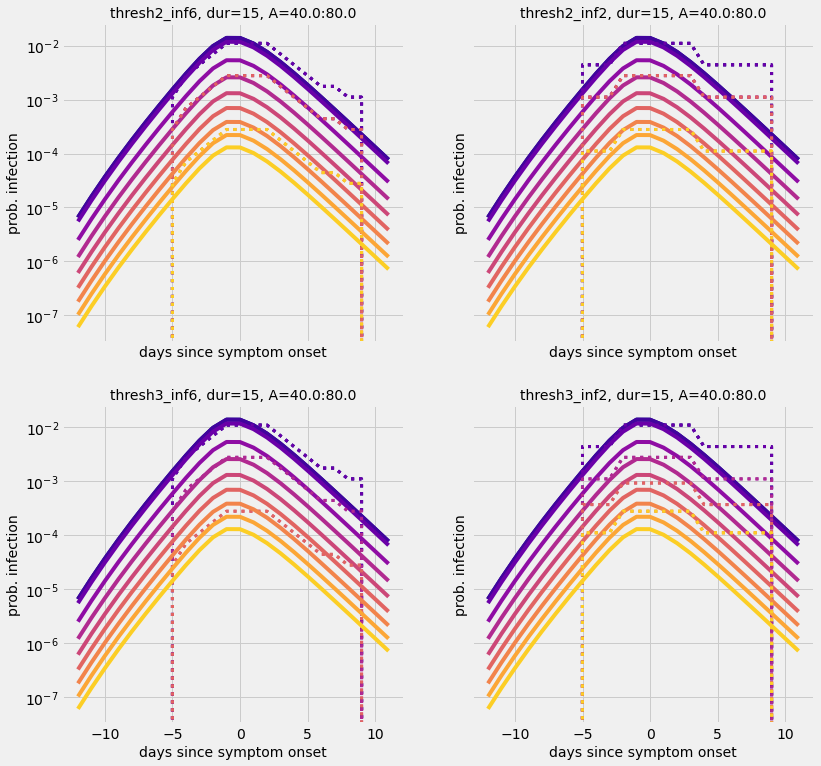

In [ ]:
attens = np.linspace(40, 80, 10, endpoint=True)
symptoms = np.arange(-12,12)
#durations = np.array([15,1*60,4*60,8*60])
duration = 15

config_list = [config_wilsonv1, config_wilsonv2, config_wilsonv3, config_wilsonv4]
fig, axs = plt.subplots(2,2, figsize=(12,12), sharex=True, sharey=True)
axs = np.reshape(axs, (4,))
for i, config in enumerate(config_list):
  plot_risk_vs_symptoms(attens, duration, symptoms, config, params, axs[i])



## ROC plots

In [ ]:
# compute min acceptible probability of infection
atten = dist_to_atten(2, ble_params)
expo = Exposure(atten=atten, duration=15, days_sym = 0)
pthresh = prob_infection(expo, params)
print(pthresh)

expo = Exposure(atten=atten, duration=15, days_sym = 5)
pthresh = prob_infection(expo, params)
print(pthresh)


0.0034904682161497336
0.00046876011717023047


In [ ]:
def make_curves_batch(attens, durations, symptoms, config, params):
  vals = itertools.product(durations, attens, symptoms)
  X = np.vstack([np.array(v) for v in vals])
  durations_grid = X[:,0]
  attens_grid = X[:,1]
  sym_grid = np.array(X[:,2], dtype=int)
  ps = prob_infection_batch(attens_grid, durations_grid, sym_grid, params)
  qs = prob_risk_score_batch(attens_grid, durations_grid, sym_grid, config)
  return ps, qs

def make_curves_batch_noise(attens, durations, symptoms, config, params, ble_params):
  distances = atten_to_dist(attens, ble_params)
  attens = dist_to_atten_sample_lognormal(distances, ble_params)
  vals = itertools.product(durations, attens, symptoms)
  X = np.vstack([np.array(v) for v in vals])
  durations_grid = X[:,0]
  attens_grid = X[:,1]
  sym_grid = np.array(X[:,2], dtype=int)
  ps = prob_infection_batch(attens_grid, durations_grid, sym_grid, params)
  qs = prob_risk_score_batch(attens_grid, durations_grid, sym_grid, config)
  return ps, qs

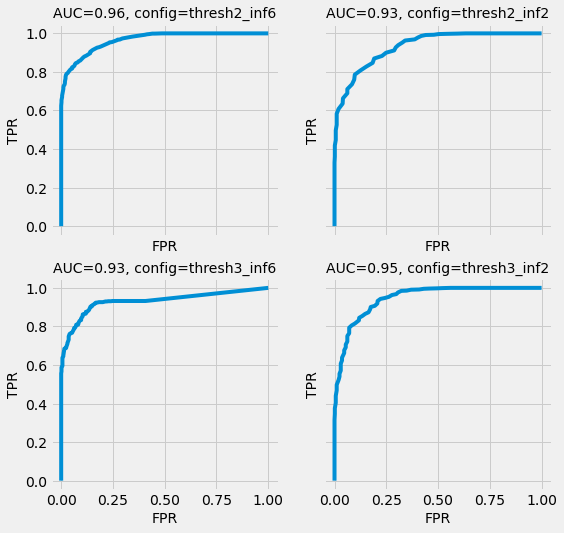

In [ ]:

import itertools

attens = np.linspace(40, 80, 10, endpoint=True)
symptoms = np.arange(-5, 10) # must be int
durations = np.linspace(5, 1*60, 10, endpoint=True)

config_list = [config_wilsonv1, config_wilsonv2, config_wilsonv3, config_wilsonv4]
#config_list = [config_wilsonv1]
fig, axs = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True)
axs = np.reshape(axs, (4,))
for i, config in enumerate(config_list):
  ps, qs = make_curves_batch(attens, durations, symptoms, config, params)
  yhat = (ps > pthresh)
  fpr, tpr, thresholds = metrics.roc_curve(yhat, qs)
  auc = metrics.auc(fpr, tpr)
  frac_pos = np.sum(yhat)/len(yhat)
  #print(frac_pos)
  ax = axs[i]
  ax.plot(fpr, tpr)
  ax.set_title('AUC={:0.2f}, config={}'.format(auc, config.name))
  ax.set_xlabel('FPR')
  ax.set_ylabel('TPR')

In [ ]:
print(ble_params)

BleParams(slope=0.21, intercept=3.92, sigma=0.5744562646538028, tx=0.0, correction=2.398, name='briers-lognormal')


## ROC with noise

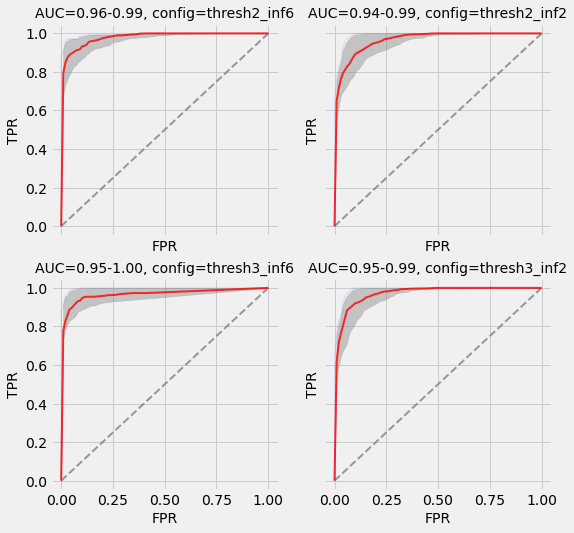

In [ ]:

import itertools


n = 10
attens = np.linspace(40, 80, 10, endpoint=True)
symptoms = np.arange(-5, 10) # must be int
durations = np.linspace(5, 1*60, 10, endpoint=True)

config_list = [config_wilsonv1, config_wilsonv2, config_wilsonv3, config_wilsonv4]
ble_params_roc = ble_params_mle

fig, axs = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True)
axs = np.reshape(axs, (4,))
for i, config in enumerate(config_list):
  tprs = []
  aucs = []
  median_fpr = np.linspace(0, 1, 100)

  np.random.seed(1041)
  for j in range(n):
    ps, qs = make_curves_batch_noise(attens, durations, symptoms,
                                     config, params, ble_params_roc)
    yhat = (ps > pthresh)
    fpr, tpr, threshold = metrics.roc_curve(yhat, qs)
    auc = metrics.auc(fpr, tpr)
    frac_pos = np.sum(yhat)/len(yhat)
    interp_tpr = np.interp(median_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc)

    if j % 10 == 0:
      ax = axs[i]
      ax.plot(fpr, tpr, color='blue', lw=1, alpha=0.1)
      ax.set_xlabel('FPR')
      ax.set_ylabel('TPR')

  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', alpha=0.8)

  median_tpr = np.median(tprs, axis=0)
  median_tpr[-1] = 1.0
  median_auc = metrics.auc(median_fpr, median_tpr)
  auc_lo = np.quantile(aucs, 0.025, axis=0)
  auc_hi = np.quantile(aucs, 0.975, axis=0)
  std_auc = np.std(aucs)
  ax.plot(median_fpr, median_tpr, color='red',
          label=r'Median ROC (AUC = %0.2f $\pm$ %0.2f)' % (median_auc, std_auc),
          lw=2, alpha=0.8)
  ax.set_title('AUC={:0.2f}-{:0.2f}, config={}'.format(auc_lo, auc_hi, config.name))

  tprs_hi = np.quantile(tprs, 0.025, axis=0)
  tprs_lo = np.quantile(tprs, 0.975, axis=0)
  ax.fill_between(median_fpr, tprs_lo, tprs_hi, color='grey', alpha=0.4,
                  label=r'$\pm$ 1 std. dev.')

  # ax.legend(loc="lower right")

# Interactive

In [ ]:
#@title # Simulation configuration

#@markdown Make selections and then **click the Play button on the left top
#@markdown corner**.

#@markdown ---

#@markdown ## Attenuation
#@markdown ### Functional form
#@markdown Default = quadratic - not implemented yet (need to simulate distances).
distance_fun = 'spline' #@param ['quadratic', 'spline'] {type:"string"}


#@markdown ### Quadratic parameters
#@markdown Any value is for D_min is possible, but for any value outwith [0, 5]
#@markdown this is a straight line (default = 1).
Dmin = 1 #@param {type:"slider", min:0.5, max:5, step:0.1}


def prob_infection_batch(attenuations, durations, symptom_days, params, Dmin, distances=None):
  if distances is None:
    distances = atten_to_dist(attenuations, params.ble_params)
  if params.distance_fun == 'quadratic':
    fd = dose_curve_quadratic(distances, Dmin)
  elif params.distance_fun == 'spline':
    fd = dose_curve_spline(distances)
  if params.infectiousness_fun == 'gaussian':
    finf = infectiousness_gaussian(symptom_days)
  elif params.infectiousness_fun == 'skew-logistic':
    finf = infectiousness_skew_logistic(symptom_days)
  doses  = durations * fd * finf
  return 1-np.exp(-params.beta * doses)

def make_curves_batch(attens, durations, symptoms, config, params, Dmin):
  vals = itertools.product(durations, attens, symptoms)
  X = np.vstack([np.array(v) for v in vals])
  durations_grid = X[:,0]
  attens_grid = X[:,1]
  sym_grid = np.array(X[:,2], dtype=int)
  ps = prob_infection_batch(attens_grid, durations_grid, sym_grid, params, Dmin)
  qs = prob_risk_score_batch(attens_grid, durations_grid, sym_grid, config)
  return ps, qs

#@markdown ### Noise in converson of attenuation to distance
#@markdown Default = 0.01
sigma = 0.01 #@param {type:"slider", min:0, max:0.05, step:0.001}
ble_params = BleParams(sigma = sigma)

#@markdown ---

#@markdown ## Infectiousness
#@markdown ### Functional form
#@markdown Default = skew-logistic
infectiousness_fun = 'skew-logistic' #@param ['skew-logistic', 'gaussian'] {type:"string"}

params = ModelParams(distance_fun = 'quadratic',
                     infectiousness_fun = infectiousness_fun)

In [ ]:
#@title # Express Notification configuration

#@markdown Make selections and then **click the Play button on the left top
#@markdown corner**.

#@markdown ---

#@markdown ## Attenuation weight (%)
immediate = 129 #@param {type:"slider", min:0, max:200, step:1}
near = 80 #@param {type:"slider", min:0, max:200, step:1}
medium = 27 #@param {type:"slider", min:0, max:200, step:1}
other = 0 #@param {type:"slider", min:0, max:200, step:1}
atten_weights = [immediate, near, medium, other]

#@markdown ---

#@markdown ## Attenuation thresholds (dB)
#@markdown Please make sure that each successive threshold is equal to or less
#@markdown than the previous.
immediate_near = 60 #@param {type:"slider", min:0, max:255, step:1}
near_medium = 70 #@param {type:"slider", min:0, max:255, step:1}
medium_far = 80 #@param {type:"slider", min:0, max:255, step:1}
atten_thresholds = [immediate_near, near_medium, medium_far]

#@markdown ---

#@markdown ## Infectiousness weight (%)
standard = 44 #@param {type:"slider", min:0, max:250, step:1}
high= 75 #@param {type:"slider", min:0, max:250, step:1}
inf_weights = [0, standard, high]

#@markdown ---

#@markdown ## Symptom onset (days since onset)
minus_14 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_13 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_12 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_11 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_10 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_09 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_08 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_07 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_06 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_05 = 'Standard' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_04 = 'Standard' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_03 = 'Standard' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_02 = 'High' #@param ['Drop', 'Standard', 'High'] {type:"string"}
minus_01 = 'High' #@param ['Drop', 'Standard', 'High'] {type:"string"}
day_zero = 'High' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_01 = 'High' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_02 = 'High' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_03 = 'High' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_04 = 'Standard' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_05 = 'Standard' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_06 = 'Standard' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_07 = 'Standard' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_08 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_09 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_10 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_11 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_12 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_13 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_14 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}
plus_15 = 'Drop' #@param ['Drop', 'Standard', 'High'] {type:"string"}

symptom_onset = [minus_14, minus_13, minus_12, minus_11, minus_10, minus_09,
                 minus_08, minus_07, minus_06, minus_05, minus_04, minus_03,
                 minus_02, minus_01, day_zero, plus_01, plus_02, plus_03,
                 plus_04, plus_05, plus_06, plus_07, plus_08, plus_09, plus_10,
                 plus_11, plus_12, plus_13, plus_14]


import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output


def infectiousness_levels():

  levels = []
  for index, level in enumerate(symptom_onset):
    if level == 'Drop':
      levels.append(0)
    elif level == 'Standard':
      levels.append(1)
    else:
      levels.append(2)

  return levels

# https://enconfig.storage.googleapis.com/enconfig_fixed.html
levels = [0] * 10 + [1, 0, 2, 1] + [2] * 4 + [1] * 6 + [0, 1, 0, 0, 1, 0]
config_default = RiskConfig(ble_thresholds = np.array([30, 50, 60]),
                           ble_weights = np.array([150, 100, 50, 0]),
                           inf_weights = np.array([0, 100, 100]),
                           inf_levels = np.array(levels),
                           name = 'Default')


config_custom = RiskConfig(ble_thresholds = np.array(atten_thresholds),
                           ble_weights = np.array(atten_weights),
                           inf_weights = np.array(inf_weights),
                           inf_levels = np.array(infectiousness_levels()),
                           name = 'Custom')

levels, weights = make_infectiousness_params_v2()

config_swiss = RiskConfig(ble_thresholds = np.array([53, 60]),
                          ble_weights = np.array([1.0, 0.5, 0.0]),
                          inf_weights = weights,
                          inf_levels = levels,
                          name= 'Switzerland')

config_germany = RiskConfig(ble_thresholds = np.array([55, 63]),
                            ble_weights = np.array([1.0, 0.5, 0.0]),
                            inf_weights = weights,
                            inf_levels = levels,
                            name= 'Germany')

config_ireland = RiskConfig(ble_thresholds = np.array([56, 62]),
                            ble_weights = np.array([1.0, 1.0, 0.0]),
                            inf_weights = weights,
                            inf_levels = levels,
                            name= 'Ireland')

config_arizona = RiskConfig(ble_thresholds = np.array([50, 70]),
                            ble_weights = np.array([2.39, 0.6, 0.06]),
                            inf_weights = weights,
                            inf_levels = levels,
                            name = 'Arizona')

ble_thresholds = {}
ble_thresholds['swiss'] = np.array([53, 60])
ble_thresholds['germany'] = np.array([55, 63])
ble_thresholds['ireland'] = np.array([56, 62])
ble_thresholds['arizona'] = np.array([50, 70])
threshold_mean = np.mean(np.array([ble_thresholds[k] for k in ble_thresholds]),
                         axis=0)

ble_weights = {}
ble_weights['swiss'] = np.array([1.0, 0.5, 0.0])
ble_weights['germany'] = np.array([1.0, 0.5, 0.0])
ble_weights['ireland'] = np.array([1.0, 1.0, 0.0])
ble_weights['arizona'] = np.array([2.39, 0.6, 0.06])
weight_mean = np.mean(np.array([ble_weights[k] for k in ble_weights]), axis=0)

config_mean = RiskConfig(ble_thresholds = threshold_mean,
                        ble_weights = weight_mean,
                        inf_weights = weights,
                        inf_levels = levels,
                        name= 'Mean')



attens = np.linspace(40, 80, 10, endpoint=True)
symptoms = np.arange(-5, 10) # must be int
durations = np.linspace(5, 1*60, 10, endpoint=True)

config_list = [config_swiss, config_germany, config_ireland, config_arizona,
               config_mean,  config_default, config_custom]

# Plot
fig, axs = plt.subplots(4,4, figsize=(24,14), sharex=True, sharey=True)
for i, config in enumerate(config_list):
  ps, qs = make_curves_batch(attens, durations, symptoms, config, params, Dmin)
  yhat = (ps > pthresh)

  # ROC
  fpr, tpr, thresholds = metrics.roc_curve(yhat, qs)
  auc = metrics.auc(fpr, tpr)
  ax = axs[int(i / 2),2 if i % 2 else 0]
  fpr_array = np.array(fpr)
  idx = [np.abs(fpr_array - 0.1).argmin()]
  ax.plot(fpr, tpr, '-go' if config.name=='Custom' else '-bo', markevery=idx)
  ax.text(fpr[idx] + 0.03, tpr[idx] - 0.07,
    ['risk = %.3f' % thresholds[i] for i in idx][0])
  ax.set_title('AUC={:0.2f}, config={}'.format(auc, config.name))
  ax.set_xlabel('FPR')
  ax.set_ylabel('TPR')

  # PR
  precision, recall, thresholds = metrics.precision_recall_curve(yhat, qs)
  auc = metrics.auc(recall, precision)
  frac_pos = np.sum(yhat)/len(yhat)
  ax = axs[int(i / 2),3 if i % 2 else 1]
  ax.plot(recall, precision, color='orange' if config.name=='Custom' else 'red')
  ax.hlines(frac_pos, 0, 1, linestyles='dashed')
  ax.text(0, frac_pos + 0.03, 'prevalence = %.2f' % frac_pos)
  ax.set_title('AUC={:0.2f}, config={}'.format(auc, config.name))
  ax.set_xlabel('Recall')
  ax.set_ylabel('Precision')